## Exploring loan risk and its associated determinants in the Peer-to-Peer (P2P) lending industry  
### *(An emphasis on data wrangling and data visualisation)*

**Contributor:** Jason Khoo

## Introduction

Peer-to-Peer (P2P) lending allows borrowers to obtain loans directly from interested lenders without traditional financial institutions acting as an intermediary. Over the years, there has been greater adoption and acceptance of online platforms such as Propser Marketplace and LendingClub that facilitate P2P lending as an alternative method of financing. This has provided greater opportunities for both the borrowers and lenders. 

For the borrowers, the interest rates for applicants with good credit standing could be lower as compared to the traditional bank rates. On the other hand, lenders could generate interest income on their free cash flows at a higher rate as compared to conventional savings or current accounts offered by traditional banks.

![image](images/loanrisk.jpg)

## Executive Summary

[A. Problem Statement and Dataset](#problem)

[B. Set Up and Preliminary Wrangling](#setup)

[C. Data Discovery](#eda)

[D. Data Wrangling and In-depth Exploratory Analysis](#data_wrang)

[E. Conclusion](#conclusion)

## A. Problem Statement and Dataset <a id = "problem"></a> 

### A(i). Problem Statement
As part of the onboarding process for borrowers, P2P online platform would usually require borrowers to provide a financial profile and the purpose of loan. Based on the information provided, a risk assessment would be carried out and a risk grade would be assigned to each loan. 

In this project, I will aim to explore the **critical determinants affecting the risk grade assigned for the loan** in the chosen dataset. 

With the above in mind, I will be primarily be focusing on the following loan attributes: 
1. Loan Amount; 
2. Loan Term;
3. Borrower's Annual Income; 
4. Loan Purpose; 
5. Home Ownership; and
6. Borrower's State

The insights gathered from the above analysis would help borrowers understand how the risk grade is assessed and possibly the loan attributes to look out for as lenders (investors) browse through the loan listing on P2P online platforms. 

### A(ii). Dataset

#### LendingClub Issued Loans Dataset 

Data source: https://www.kaggle.com/husainsb/lendingclub-issued-loans

The above dataset contains 759,338 loan records with 72 variables over the period from 2016 to 2017 in the United States region. Some variables include (1) interest rate, (2) grade, (3) state, and (4) loan amount.

## B. Set Up and Preliminary Wrangling <a id = "setup"></a> 

In this section, the set up procedures (e.g. import required python packages, dataset loading) are performed.

Thereafter, a basic exploration on the shape and structure of the data frame is carried out and a high level data frame cleansing (e.g. remove duplicated loans, datatypes specification, null value treatment) is performed.

### B(i) Import the python packages

In [1]:
#import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import geopandas as gpd
from shapely.geometry import Point
import fiona 
import bokeh
from bokeh import io
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.transform import linear_cmap,factor_cmap
from bokeh.tile_providers import CARTODBPOSITRON_RETINA, get_provider 
from bokeh.palettes import PRGn
from bokeh.models import LinearColorMapper, ColorBar, NumeralTickFormatter
from bokeh.resources import INLINE
import bokeh.io

#install wordcloud
#conda install -c conda-forge wordcloud
#install fiona
#conda install -c conda-forge fiona

### B(ii) Load the dataset

In [2]:
#load csv file
dataframe1 = pd.read_csv("dataset/loan_dataset.csv",header=0)

#view the first few rows of the dataset
print(dataframe1.head)

/Users/jasonkhoo/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (18,54) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<bound method NDFrame.head of                id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
0       112435993        NaN       2300         2300           2300.0   
1       112290210        NaN      16000        16000          16000.0   
2       112436985        NaN       6025         6025           6025.0   
3       112439006        NaN      20400        20400          20400.0   
4       112438929        NaN      13000        13000          13000.0   
...           ...        ...        ...          ...              ...   
759333   65854936        NaN       6000         6000           6000.0   
759334   66055600        NaN       6000         6000           6000.0   
759335   66141895        NaN      14400        14400          14400.0   
759336   65673209        NaN      34050        34050          34050.0   
759337   65744272        NaN       5000         5000           5000.0   

             term  int_rate  installment grade sub_grade  ... total_bal_il  \
0       36 mont

### (B)(iii) Dataframe Attributes

In [3]:
#view the dataframe attributes
print(dataframe1.info())
print("\n", dataframe1.columns)
print("\n", dataframe1.shape)
print("\n", dataframe1.index)
print("\n", dataframe1.values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759338 entries, 0 to 759337
Data columns (total 72 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           759338 non-null  int64  
 1   member_id                    0 non-null       float64
 2   loan_amnt                    759338 non-null  int64  
 3   funded_amnt                  759338 non-null  int64  
 4   funded_amnt_inv              759338 non-null  float64
 5   term                         759338 non-null  object 
 6   int_rate                     759338 non-null  float64
 7   installment                  759338 non-null  float64
 8   grade                        759338 non-null  object 
 9   sub_grade                    759338 non-null  object 
 10  emp_title                    708368 non-null  object 
 11  emp_length                   708975 non-null  object 
 12  home_ownership               759338 non-null  object 
 13 

### B(iv) Dataframe Cleansing

#### 1. Verify that there are no duplicated loans (identified by 'id' number)

In [4]:
#check for duplicates using id
print(dataframe1['id'].duplicated())
print("---------------------------")

print("Any duplicated loans (identified by 'id' number):")
print(dataframe1['id'].duplicated().any())
print(dataframe1['id'].duplicated().sum())

0         False
1         False
2         False
3         False
4         False
          ...  
759333    False
759334    False
759335    False
759336    False
759337    False
Name: id, Length: 759338, dtype: bool
---------------------------
Any duplicated loans (identified by 'id' number):
False
0


#### 2. Specify the datatypes for columns

In [5]:
#changing date/time data columns to datetime[ns]
dataframe1['issue_d'] = dataframe1['issue_d'].astype('datetime64[ns]')

#changing the remaining columns to appropriate datatypes
dataframe1['term'] = dataframe1['term'].astype('category')
dataframe1['grade'] = dataframe1['grade'].astype('category')
dataframe1['home_ownership'] = dataframe1['home_ownership'].astype('category')
dataframe1['title'] = dataframe1['title'].astype('category')
dataframe1['addr_state'] = dataframe1['addr_state'].astype('category')
dataframe1['loan_status'] = dataframe1['loan_status'].astype('category')

In [6]:
#view info after dataframe cleansing
print(dataframe1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759338 entries, 0 to 759337
Data columns (total 72 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   id                           759338 non-null  int64         
 1   member_id                    0 non-null       float64       
 2   loan_amnt                    759338 non-null  int64         
 3   funded_amnt                  759338 non-null  int64         
 4   funded_amnt_inv              759338 non-null  float64       
 5   term                         759338 non-null  category      
 6   int_rate                     759338 non-null  float64       
 7   installment                  759338 non-null  float64       
 8   grade                        759338 non-null  category      
 9   sub_grade                    759338 non-null  object        
 10  emp_title                    708368 non-null  object        
 11  emp_length                

#### 3. Null values in Dataframe

> #### i. Inspect Null Values

In [7]:
#check for null / nan values
print(dataframe1.isnull().values.any()) 

True


In [8]:
#get the list of columns with missing values
print(dataframe1.columns[dataframe1.isnull().any()]) 

Index(['member_id', 'emp_title', 'emp_length', 'desc', 'title', 'zip_code',
       'dti', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'revol_util', 'last_pymnt_d', 'next_pymnt_d',
       'last_credit_pull_d', 'mths_since_last_major_derog', 'annual_inc_joint',
       'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_12m',
       'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util',
       'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi',
       'total_cu_tl', 'inq_last_12m'],
      dtype='object')


In [9]:
#obtain the number of of missing data per column
null_counts = dataframe1.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts)) 

Number of null values in each column:
id                       0
member_id           759338
loan_amnt                0
funded_amnt              0
funded_amnt_inv          0
                     ...  
all_util               114
total_rev_hi_lim         0
inq_fi                  61
total_cu_tl             62
inq_last_12m            62
Length: 72, dtype: int64


> #### ii. Evaluate Null Values

In [10]:
#Evaluate missing values against total in percentage format
for column in dataframe1.columns:
    missing_pct = np.mean(dataframe1[column].isnull())
    print('{} - {}%'.format(column, round(missing_pct*100)))

id - 0%
member_id - 100%
loan_amnt - 0%
funded_amnt - 0%
funded_amnt_inv - 0%
term - 0%
int_rate - 0%
installment - 0%
grade - 0%
sub_grade - 0%
emp_title - 7%
emp_length - 7%
home_ownership - 0%
annual_inc - 0%
verification_status - 0%
issue_d - 0%
loan_status - 0%
pymnt_plan - 0%
desc - 100%
purpose - 0%
title - 3%
zip_code - 0%
addr_state - 0%
dti - 0%
delinq_2yrs - 0%
earliest_cr_line - 0%
inq_last_6mths - 0%
mths_since_last_delinq - 48%
mths_since_last_record - 81%
open_acc - 0%
pub_rec - 0%
revol_bal - 0%
revol_util - 0%
total_acc - 0%
initial_list_status - 0%
out_prncp - 0%
out_prncp_inv - 0%
total_pymnt - 0%
total_pymnt_inv - 0%
total_rec_prncp - 0%
total_rec_int - 0%
total_rec_late_fee - 0%
recoveries - 0%
collection_recovery_fee - 0%
last_pymnt_d - 0%
last_pymnt_amnt - 0%
next_pymnt_d - 22%
last_credit_pull_d - 0%
collections_12_mths_ex_med - 0%
mths_since_last_major_derog - 72%
policy_code - 0%
application_type - 0%
annual_inc_joint - 96%
dti_joint - 96%
verification_status_

> #### iii. Visualise Null Values

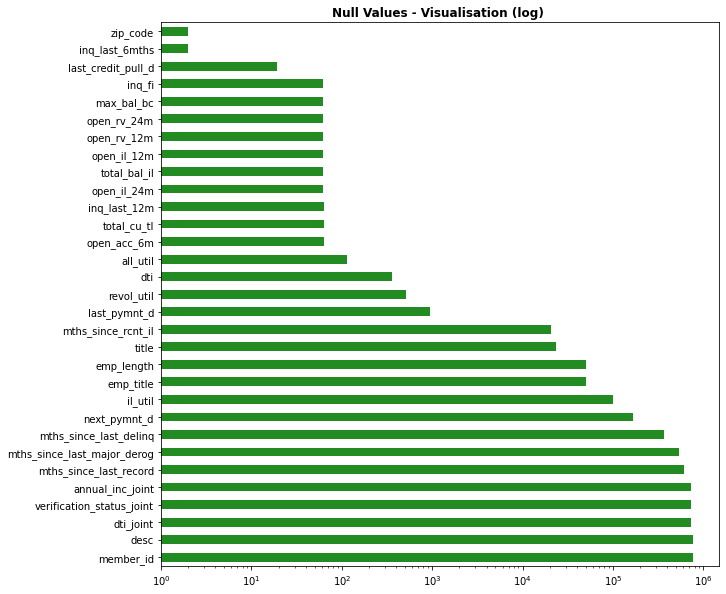

In [11]:
#visualise columns with missingno
missingcat=['member_id', 'emp_title', 'emp_length', 'desc', 'title', 'zip_code',
       'dti', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'revol_util', 'last_pymnt_d', 'next_pymnt_d',
       'last_credit_pull_d', 'mths_since_last_major_derog', 'annual_inc_joint',
       'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_12m',
       'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util',
       'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi',
       'total_cu_tl', 'inq_last_12m']

#set the figure size for the plot
plt.figure(figsize=(10,10)) 

#plot barh chart
dataframe1[missingcat].isnull().sum().sort_values(ascending=False).plot(kind='barh',log=True,color='forestgreen')

#set title
plt.title('Null Values - Visualisation (log) ',fontweight="bold",fontsize=12)

plt.show()

## C. Data Discovery <a id = "eda"></a> 

In this section, a basic data discovery on the distribution of the risk grade (i.e. 'grade' column) and the potential risk determinants is performed. The geographic location of the loans and the relationship between the risk grade and the interest rate have also been explored. 

### C(i) Distribution of Risk Grade

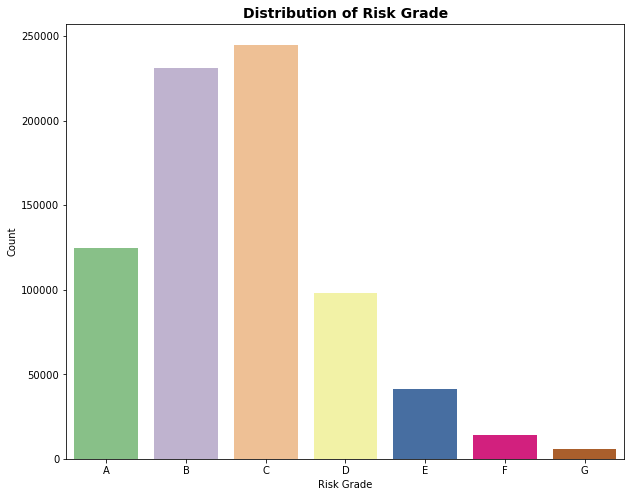

In [12]:
#set the figure size for the plot
plt.figure(figsize=(10,8))

#countplot
sns.countplot(x='grade',data=dataframe1,palette='Accent')

#x-axis, y-axis and title adjustment and labelling
plt.xticks(rotation=0)
plt.xlabel('Risk Grade')
plt.ylabel('Count')
plt.title('Distribution of Risk Grade',fontweight="bold",fontsize=14)

plt.show()

- A large proportion of loans carries the 'A' - 'D' risk grade, with 'C' risk grade loan being the most common
- 'A' risk grade signifies the best loan quality, while 'G' risk grade signifies the worst loan quality

### C(ii) Distribution of Interested Attributes

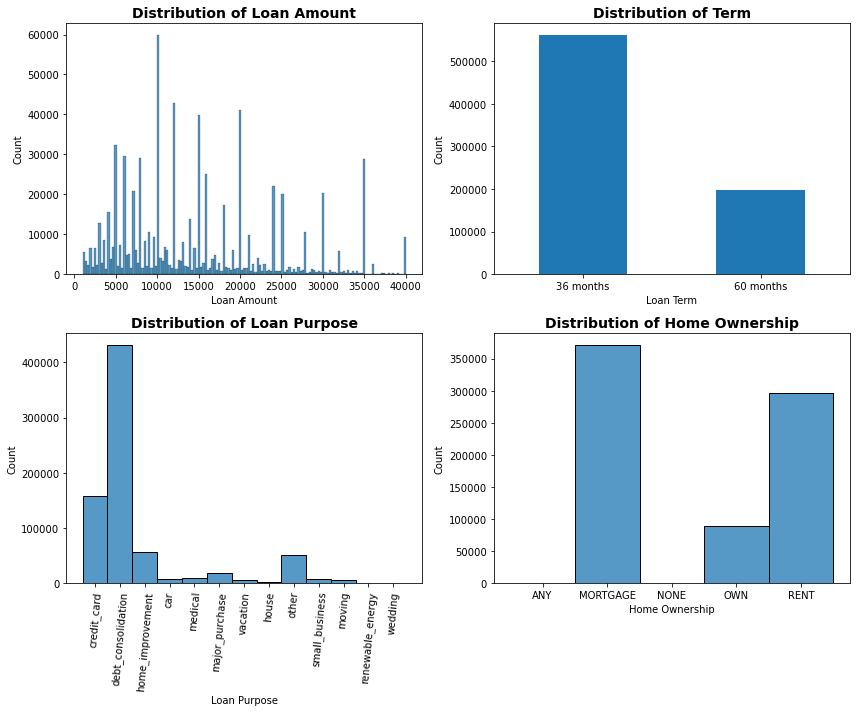

In [13]:
#Histogram on the count of 1. Loan Amount, 2. Loan Term, 3. Loan Purpose, 4. Home Ownership 
#set the figure size for the plot
plt.figure(figsize=(12,10))

#Subplot for Loan Amount
plt.subplot(2,2,1)
sns.histplot(data=dataframe1,x='loan_amnt')
#x-axis, y-axis and title adjustment and labelling
plt.xlabel('Loan Amount')
plt.ylabel('Count')
plt.title('Distribution of Loan Amount',fontweight="bold",fontsize=14)

#Subplot for Loan Term
plt.subplot(2,2,2)
dataframe1["term"].value_counts().plot(kind="bar")
#x-axis, y-axis and title adjustment and labelling
plt.xticks(rotation=0)
plt.xlabel('Loan Term')
plt.ylabel('Count')
plt.title('Distribution of Term',fontweight="bold",fontsize=14)

#Subplot for Loan Purpose
plt.subplot(2,2,3)
sns.histplot(data=dataframe1,x='purpose')
#x-axis, y-axis and title adjustment and labelling
plt.xticks(rotation=85)
plt.xlabel('Loan Purpose')
plt.ylabel('Count')
plt.title('Distribution of Loan Purpose',fontweight="bold",fontsize=14)

#Subplot for Home Ownership
plt.subplot(2,2,4)
sns.histplot(data=dataframe1,x='home_ownership')
#x-axis, y-axis and title adjustment and labelling
plt.xlabel('Home Ownership')
plt.ylabel('Count')
plt.title('Distribution of Home Ownership',fontweight="bold",fontsize=14)

#Auto adjust padding between subplots
plt.tight_layout()

plt.show()

- **Loan Amount:** Most loans are concentrated at the loan amount where it is rounded (e.g. 5k, 10k, 15k, 20k, etc.), there are more loans that are lower than 10k comparatively
- **Loan Term:** 36 months loan is more common and available compared to 60 months loan
- **Loan Purpose:** Most loans are used for debt consolidation followed by credit card financing
- **Home Ownership:** Most borrowers has 'mortage' and 'rent' home ownership

### C(iii) Loan Amount and Annual Income

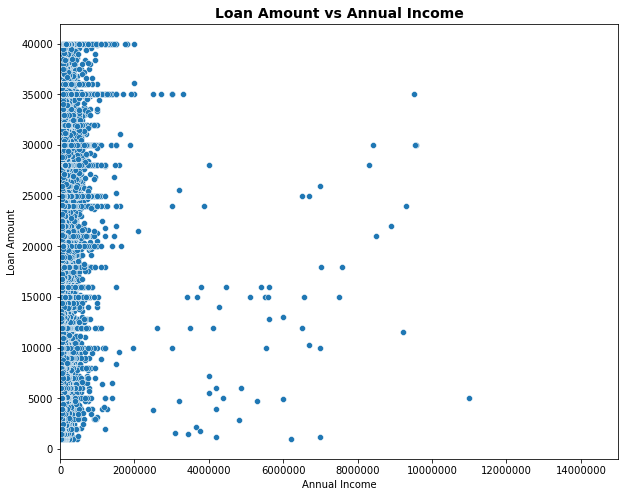

In [14]:
#set the figure size for the plot
plt.figure(figsize=(10,8))

#scatter
sns.scatterplot(x='annual_inc',y='loan_amnt',data=dataframe1)

#x-axis, y-axis and title adjustment and labelling
plt.xticks(rotation=0)
plt.xlabel('Annual Income')
plt.ylabel('Loan Amount')
plt.title('Loan Amount vs Annual Income',fontweight="bold",fontsize=14)

#magnify the plot
plt.xlim(0,15000000)

#Change the y-axis to full numerical format instead of scientific format
plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)

plt.show()

- Borrowers that has high annual income do not borrow a higher loan amount
- It appears that high loan amounts are borrowed by low income borrowers as well

### C(iv) Geographic Distribution of the Loans

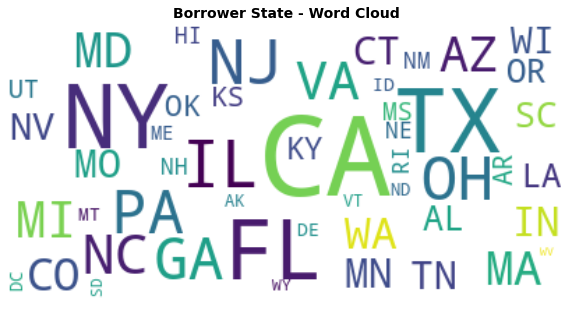

In [15]:
#set the figure size for the plot
plt.figure(figsize=(10,8)) 

# Targeted text within the column
text = dataframe1["addr_state"].value_counts().to_dict()

# Create and generate a word cloud image
wordcloud = WordCloud(max_font_size=80, max_words=100, 
                      background_color="white").generate_from_frequencies(text)

# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Borrower State - Word Cloud',fontweight="bold",fontsize=14)
plt.show()

- California has the most loans, followed by Texas, Florida and New York

### C(v) Risk Grade and Interest Rate

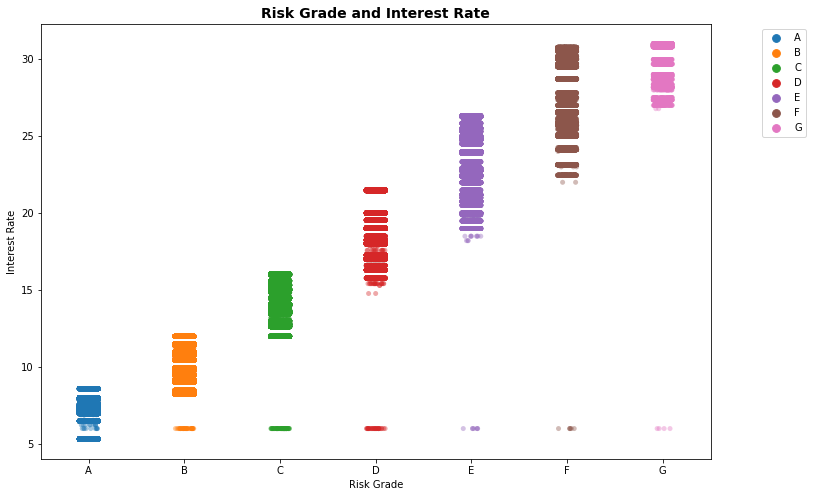

In [16]:
#set the figure size for the plot
plt.figure(figsize=(12,8))

#stripplot
sns.stripplot(data=dataframe1, x="grade", y="int_rate",hue="grade", alpha=0.4)

#adjust legend to out of figure frame
plt.legend(bbox_to_anchor=(1.15,1))

#x-axis, y-axis and title adjustment and labelling
plt.xlabel('Risk Grade')
plt.ylabel('Interest Rate')
plt.title('Risk Grade and Interest Rate',fontweight="bold",fontsize=14)

# show the graph
plt.show()

- Better quality loans (e.g. 'A' risk grade) tend to have a lower interest rate
- 'E' and 'F' risk grade loans tend to have a larger interest rate spread as compared to the other risk grade loans

## D. Data Wrangling and In-depth Exploratory Analysis <a id = "data_wrang"></a> 

### D(i) Data Wrangling
Based on the results from the preliminary wrangling, additional data wrangling procedures are performed to cleanse the data for analysis, e.g. grouping data fields into predefined categories and recoding for statistical analysis.

#### 1. Remapping of the fields in Risk Grade into a new categorical field

In [17]:
#view the unique values of 'grade' column
print(dataframe1['grade'].unique())

['C', 'B', 'A', 'E', 'F', 'D', 'G']
Categories (7, object): ['A', 'B', 'C', 'D', 'E', 'F', 'G']


In [18]:
#slice out the 'grade' column for analysis
risk_rating = dataframe1[['grade']]
print(risk_rating.head())
print("---------------------------")

#specify the mapping for the fields
risk_rating_remap ={'A':'1. Low Risk',
                    'B':'1. Low Risk',
                    'C':'2. Mid Risk',
                    'D':'2. Mid Risk',
                    'E':'2. Mid Risk',
                    'F':'3. High Risk',
                    'G':'3. High Risk'}

#replace fields with the new mapping
risk_rating=risk_rating.replace({'grade':risk_rating_remap})
print(risk_rating.head())

#put the new mapping column back in the main dataframe1
dataframe1['grade_categorical'] = risk_rating
print("---------------------------")
print(dataframe1.head())

  grade
0     C
1     C
2     C
3     B
4     B
---------------------------
         grade
0  2. Mid Risk
1  2. Mid Risk
2  2. Mid Risk
3  1. Low Risk
4  1. Low Risk
---------------------------
          id  member_id  loan_amnt  funded_amnt  funded_amnt_inv       term  \
0  112435993        NaN       2300         2300           2300.0  36 months   
1  112290210        NaN      16000        16000          16000.0  60 months   
2  112436985        NaN       6025         6025           6025.0  36 months   
3  112439006        NaN      20400        20400          20400.0  36 months   
4  112438929        NaN      13000        13000          13000.0  36 months   

   int_rate  installment grade sub_grade  ... il_util open_rv_12m open_rv_24m  \
0     12.62        77.08     C        C1  ...     NaN         1.0         2.0   
1     12.62       360.95     C        C1  ...    69.0         3.0         5.0   
2     15.05       209.01     C        C4  ...     NaN         1.0         2.0   
3      

#### 2. Recoding of the Risk Grade into numerical form

In [19]:
#slice out the 'grade' column for analysis
risk_rating_num = dataframe1[['grade']]
print(risk_rating_num.head())
print("---------------------------")

#specify the mapping for the fields
risk_rating_num_remap ={'A':1,
                    'B':2,
                    'C':3,
                    'D':4,
                    'E':5,
                    'F':6,
                    'G':7}

#replace fields with the new mapping
risk_rating_num=risk_rating_num.replace({'grade':risk_rating_num_remap})
print(risk_rating_num.head())

#put the new mapping column back in the main dataframe1
dataframe1['grade_numerical'] = risk_rating_num
print("---------------------------")
print(dataframe1.head())

  grade
0     C
1     C
2     C
3     B
4     B
---------------------------
   grade
0      3
1      3
2      3
3      2
4      2
---------------------------
          id  member_id  loan_amnt  funded_amnt  funded_amnt_inv       term  \
0  112435993        NaN       2300         2300           2300.0  36 months   
1  112290210        NaN      16000        16000          16000.0  60 months   
2  112436985        NaN       6025         6025           6025.0  36 months   
3  112439006        NaN      20400        20400          20400.0  36 months   
4  112438929        NaN      13000        13000          13000.0  36 months   

   int_rate  installment grade sub_grade  ... open_rv_12m open_rv_24m  \
0     12.62        77.08     C        C1  ...         1.0         2.0   
1     12.62       360.95     C        C1  ...         3.0         5.0   
2     15.05       209.01     C        C4  ...         1.0         2.0   
3      9.44       652.91     B        B1  ...         1.0         2.0   
4 

#### 3. Remapping of the fields in Home Ownership into a new categorical field

In [20]:
#view the unique values of 'home_ownership' column
print(dataframe1['home_ownership'].unique())

['OWN', 'MORTGAGE', 'RENT', 'ANY', 'NONE']
Categories (5, object): ['ANY', 'MORTGAGE', 'NONE', 'OWN', 'RENT']


In [21]:
#slice out the 'home_ownership' column for analysis
own_home = dataframe1[['home_ownership']]
print(own_home.head())
print("---------------------------")

#specify the mapping for the fields (treat only 'OWN' as 1, the rest as 0)
own_home_remap ={'ANY':0,
                    'MORTGAGE':0,
                    'NONE':0,
                    'OWN':1,
                    'RENT':0}

#replace fields with the new mapping
own_home=own_home.replace({'home_ownership':own_home_remap})
print(own_home.head())

#put the new mapping column back in the main dataframe1
dataframe1['home_ownership_binary'] = own_home
print("---------------------------")
print(dataframe1.head())

  home_ownership
0            OWN
1       MORTGAGE
2       MORTGAGE
3           RENT
4       MORTGAGE
---------------------------
   home_ownership
0               1
1               0
2               0
3               0
4               0
---------------------------
          id  member_id  loan_amnt  funded_amnt  funded_amnt_inv       term  \
0  112435993        NaN       2300         2300           2300.0  36 months   
1  112290210        NaN      16000        16000          16000.0  60 months   
2  112436985        NaN       6025         6025           6025.0  36 months   
3  112439006        NaN      20400        20400          20400.0  36 months   
4  112438929        NaN      13000        13000          13000.0  36 months   

   int_rate  installment grade sub_grade  ... open_rv_24m max_bal_bc all_util  \
0     12.62        77.08     C        C1  ...         2.0     2315.0     55.0   
1     12.62       360.95     C        C1  ...         5.0     1962.0     94.0   
2     15.05     

#### 4. Remapping of the fields in Loan Status into a new categorical field

In [22]:
#view the unique values of 'loan_status' column
print(dataframe1['loan_status'].unique())

['Current', 'Fully Paid', 'In Grace Period', 'Late (31-120 days)', 'Late (16-30 days)', 'Charged Off', 'Default']
Categories (7, object): ['Charged Off', 'Current', 'Default', 'Fully Paid', 'In Grace Period', 'Late (16-30 days)', 'Late (31-120 days)']


In [23]:
#slice out the 'loan_status' column for analysis
loan_stat = dataframe1[['loan_status']]
print(loan_stat.head())
print("---------------------------")

#specify the mapping for the fields (treat only 'Charged Off', 'Default', 'Late (16-30 days)', 'Late (31-120 days)'as 1 (Bad loans), 'Current' as 2, the rest as 0 (Good loans))
loan_stat_remap ={'Charged Off':1,
                    'Current':2,
                    'Default':1,
                    'Fully Paid':0,
                    'In Grace Period':0,
                     'Late (16-30 days)':1,
                     'Late (31-120 days)':1}

#replace fields with the new mapping
loan_stat=loan_stat.replace({'loan_status':loan_stat_remap})
print(loan_stat.head())

#put the new mapping column back in the main dataframe1
dataframe1['loan_stat_cat'] = loan_stat
print("---------------------------")
print(dataframe1.head())

  loan_status
0     Current
1     Current
2     Current
3     Current
4     Current
---------------------------
   loan_status
0            2
1            2
2            2
3            2
4            2
---------------------------
          id  member_id  loan_amnt  funded_amnt  funded_amnt_inv       term  \
0  112435993        NaN       2300         2300           2300.0  36 months   
1  112290210        NaN      16000        16000          16000.0  60 months   
2  112436985        NaN       6025         6025           6025.0  36 months   
3  112439006        NaN      20400        20400          20400.0  36 months   
4  112438929        NaN      13000        13000          13000.0  36 months   

   int_rate  installment grade sub_grade  ... max_bal_bc all_util  \
0     12.62        77.08     C        C1  ...     2315.0     55.0   
1     12.62       360.95     C        C1  ...     1962.0     94.0   
2     15.05       209.01     C        C4  ...     1950.0     45.0   
3      9.44       6

#### 5. Recoding of the Loan Term into numerical form

In [24]:
#view the unique values of 'term' column
print(dataframe1['term'].unique())

['36 months', '60 months']
Categories (2, object): ['36 months', '60 months']


In [25]:
#slice out the 'term' column for analysis
term_num = dataframe1[['term']]
print(term_num.head())
print("---------------------------")

#specify the mapping for the fields
term_num_remap ={'36 months':1,
                '60 months':2}

#replace fields with the new mapping
term_num=term_num.replace({'term':term_num_remap})
print(risk_rating_num.head())

#put the new mapping column back in the main dataframe1
dataframe1['term_num'] = term_num
print("---------------------------")
print(dataframe1.head())

        term
0  36 months
1  60 months
2  36 months
3  36 months
4  36 months
---------------------------
   grade
0      3
1      3
2      3
3      2
4      2
---------------------------
          id  member_id  loan_amnt  funded_amnt  funded_amnt_inv       term  \
0  112435993        NaN       2300         2300           2300.0  36 months   
1  112290210        NaN      16000        16000          16000.0  60 months   
2  112436985        NaN       6025         6025           6025.0  36 months   
3  112439006        NaN      20400        20400          20400.0  36 months   
4  112438929        NaN      13000        13000          13000.0  36 months   

   int_rate  installment grade sub_grade  ... all_util total_rev_hi_lim  \
0     12.62        77.08     C        C1  ...     55.0           7100.0   
1     12.62       360.95     C        C1  ...     94.0          31900.0   
2     15.05       209.01     C        C4  ...     45.0          27700.0   
3      9.44       652.91     B       

#### 6. Recoding of the Loan Purpose into numerical form

In [26]:
#view the unique values of 'purpose' column
print(dataframe1['purpose'].unique())

['credit_card' 'debt_consolidation' 'home_improvement' 'car' 'medical'
 'major_purchase' 'vacation' 'house' 'other' 'small_business' 'moving'
 'renewable_energy' 'wedding']


In [27]:
#slice out the 'purpose' column for analysis
purpose_num = dataframe1[['purpose']]
print(purpose_num.head())
print("---------------------------")

#specify the mapping for the fields
purpose_num_remap ={'credit_card':1,
                    'debt_consolidation':2,
                    'home_improvement':3,
                    'car':4,
                    'medical':5,
                    'major_purchase':6,
                    'vacation':7,
                    'house':8,
                    'other':9,
                    'small_business':10,
                    'moving':11,
                    'renewable_energy':12,
                    'wedding':13}

#replace fields with the new mapping
purpose_num=purpose_num.replace({'purpose':purpose_num_remap})
print(purpose_num.head())

#put the new mapping column back in the main dataframe1
dataframe1['purpose_num'] = purpose_num
print("---------------------------")
print(dataframe1.head())

              purpose
0         credit_card
1  debt_consolidation
2    home_improvement
3                 car
4  debt_consolidation
---------------------------
   purpose
0        1
1        2
2        3
3        4
4        2
---------------------------
          id  member_id  loan_amnt  funded_amnt  funded_amnt_inv       term  \
0  112435993        NaN       2300         2300           2300.0  36 months   
1  112290210        NaN      16000        16000          16000.0  60 months   
2  112436985        NaN       6025         6025           6025.0  36 months   
3  112439006        NaN      20400        20400          20400.0  36 months   
4  112438929        NaN      13000        13000          13000.0  36 months   

   int_rate  installment grade sub_grade  ... total_rev_hi_lim inq_fi  \
0     12.62        77.08     C        C1  ...           7100.0    1.0   
1     12.62       360.95     C        C1  ...          31900.0    0.0   
2     15.05       209.01     C        C4  ...       

#### 7. Remapping of the fields in Loan Amount into a grouped categories

In [28]:
#slice out the 'loan_amount' column for analysis
loan_amt = dataframe1[['loan_amnt']]
print(loan_amt.head())
print("---------------------------")

#group the loan amount into 4 categories (1. $0-$10k, 2. $10,001-$20k, 3. $20,001-$30k, 4. $30,001-$40k)
loan_amt['loan_amnt_cat']=pd.cut(loan_amt['loan_amnt'],[0,10000,20000,30000,40000],precision=0,labels=['1. $0-$10k', '2. $10,001-$20k', '3. $20,001-$30k', '4. $30,001-$40k'])
print(loan_amt.head())

#put the new column back in the main dataframe1
dataframe1['loan_amnt_cat'] = loan_amt['loan_amnt_cat']
print("---------------------------")
print(dataframe1.head())

   loan_amnt
0       2300
1      16000
2       6025
3      20400
4      13000
---------------------------
   loan_amnt    loan_amnt_cat
0       2300       1. $0-$10k
1      16000  2. $10,001-$20k
2       6025       1. $0-$10k
3      20400  3. $20,001-$30k
4      13000  2. $10,001-$20k
---------------------------
          id  member_id  loan_amnt  funded_amnt  funded_amnt_inv       term  \
0  112435993        NaN       2300         2300           2300.0  36 months   
1  112290210        NaN      16000        16000          16000.0  60 months   
2  112436985        NaN       6025         6025           6025.0  36 months   
3  112439006        NaN      20400        20400          20400.0  36 months   
4  112438929        NaN      13000        13000          13000.0  36 months   

   int_rate  installment grade sub_grade  ... inq_fi total_cu_tl inq_last_12m  \
0     12.62        77.08     C        C1  ...    1.0         0.0          2.0   
1     12.62       360.95     C        C1  ...    

/var/folders/33/x2g0s9_s2p54gh0q9hx3551r0000gn/T/ipykernel_998/3145214597.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_amt['loan_amnt_cat']=pd.cut(loan_amt['loan_amnt'],[0,10000,20000,30000,40000],precision=0,labels=['1. $0-$10k', '2. $10,001-$20k', '3. $20,001-$30k', '4. $30,001-$40k'])


### D(ii) In-depth Exploratory Analysis

In this section, a bivariate exploration on the loan risk and its associated determinants is performed. 

In preparing the dataset for data visualisation to showcase the relationships between loan risk and the determinants, additional preparatory wrangling procedures are performed.

#### 1. Correlation Matrix

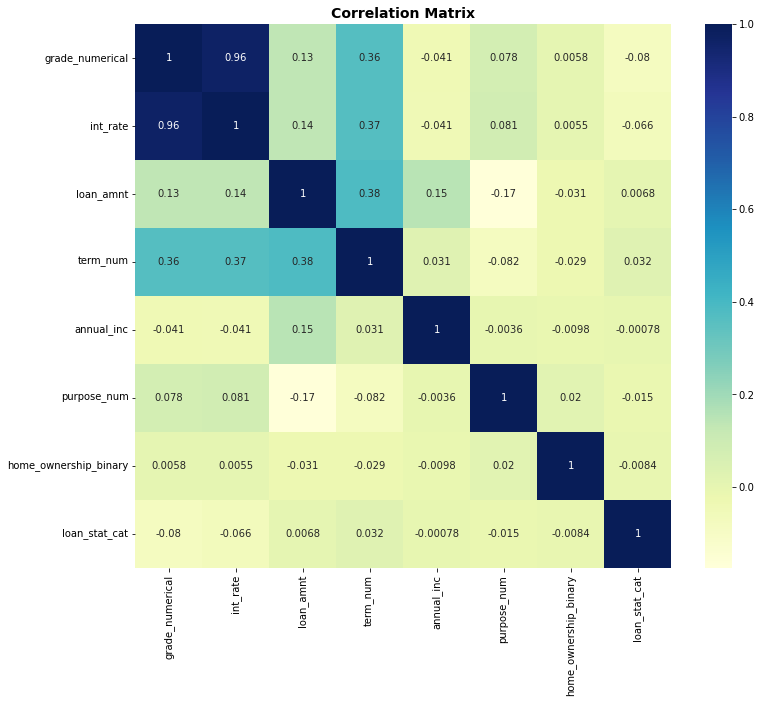

In [29]:
#Select variables to test for correlation
correlation_variables = ['grade_numerical','int_rate','loan_amnt','term_num','annual_inc','purpose_num','home_ownership_binary','loan_stat_cat']

#set the figure size for the plot
plt.figure(figsize=(12,10)) 

#Seaborn Heatmap for Correlation
sns.heatmap(dataframe1[correlation_variables].corr(),annot=True,fmt='.2g',cmap="YlGnBu").set_title('Correlation Matrix',fontweight="bold",fontsize=14)

# show the graph
plt.show()

- The above results signify a strong correlation between the risk grade and the interest rate
- The correlation between risk and the other variables seems weak, we will explore the relationships further in our analysis

#### 2. Loan Risk and Loan Status 

> #### Slicing and removal of "Current" loan status

In [30]:
#Slice to get the grade_categorical and loan_stat_cat
status_outcome = dataframe1[['grade_categorical','loan_stat_cat']]

#Drop rows with "Current" loan status
index_current = status_outcome[status_outcome['loan_stat_cat']==2].index
status_outcome.drop(index_current,inplace=True)

print(status_outcome.head())

   grade_categorical  loan_stat_cat
8        1. Low Risk              0
10       2. Mid Risk              0
24       1. Low Risk              0
42       2. Mid Risk              0
91       2. Mid Risk              0


/Users/jasonkhoo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


> #### Stacked Bar Chart

grade_categorical  1. Low Risk  2. Mid Risk  3. High Risk
loan_stat_cat                                            
0                        63396        69751          4205
1                        13221        38420          4822
grade_categorical  1. Low Risk  2. Mid Risk  3. High Risk
loan_stat_cat                                            
0                    46.155862    50.782661      3.061477
1                    23.415334    68.044560      8.540106


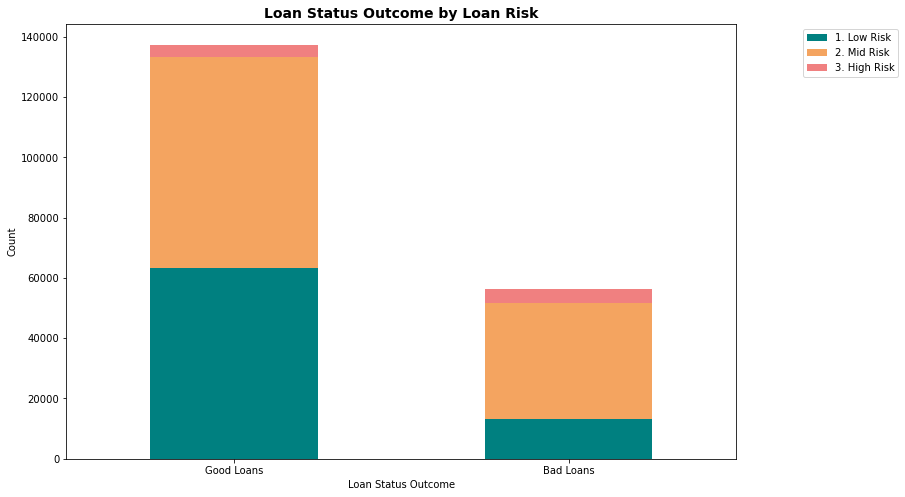

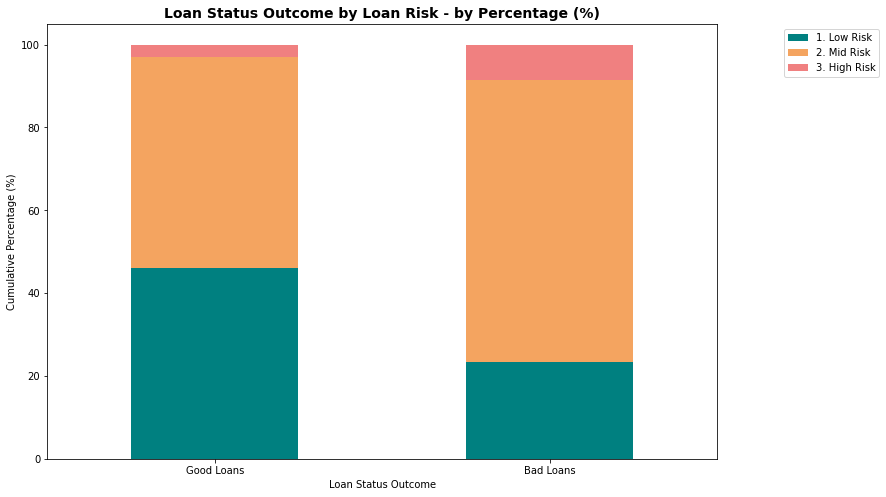

In [31]:
#set colors
colors=['teal','sandybrown','lightcoral']

#Plot the bar chart
status_outcome_grouped = status_outcome.groupby(['loan_stat_cat','grade_categorical'])['loan_stat_cat'].count().unstack('grade_categorical')
#display aggregated data
print(status_outcome_grouped)
status_outcome_grouped.plot(kind='bar',stacked=True,figsize=(12,8),color=colors)
#adjust legend to out of figure frame
plt.legend(bbox_to_anchor=(1.25,1))
#x-axis, y-axis and title adjustment and labelling
plt.ylabel('Count')
plt.xlabel('Loan Status Outcome')
plt.xticks(ticks=[0,1],labels=['Good Loans','Bad Loans'],rotation=0)
plt.title('Loan Status Outcome by Loan Risk',fontweight="bold",fontsize=14)

#bar chart by percentage
status_outcome_grouped2 = status_outcome_grouped.div(status_outcome_grouped.sum(axis=1),axis=0)*100
#display aggregated data
print(status_outcome_grouped2)
status_outcome_grouped2.plot(kind='bar',stacked=True,figsize=(12,8),color=colors)
#adjust legend to out of figure frame
plt.legend(bbox_to_anchor=(1.25,1))
#x-axis, y-axis and title adjustment and labelling
plt.ylabel('Cumulative Percentage (%)')
plt.xlabel('Loan Status Outcome')
plt.xticks(ticks=[0,1],labels=['Good Loans','Bad Loans'],rotation=0)
plt.title('Loan Status Outcome by Loan Risk - by Percentage (%)',fontweight="bold",fontsize=14)

# show the graph
plt.show()

- Most loans on LendingClub turned out to be good loans
- In terms of percentage, good loans has more low risk loans and lower high risk loans as compared to loans that turned out bad
- Risk is an important consideration as it might affect how the loan turned out to be

#### 3. Loan Risk and Loan Amount

> #### Scatter Plot

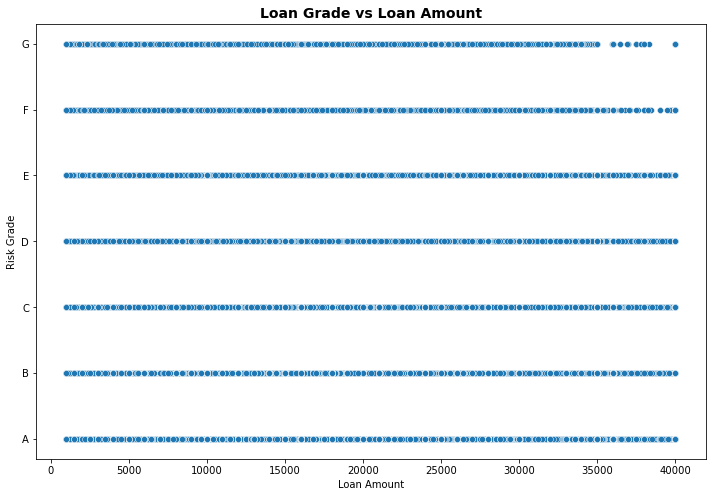

In [32]:
#set the figure size for the plot
plt.figure(figsize=(12,8))

#scatter
sns.scatterplot(x='loan_amnt',y='grade_numerical',data=dataframe1)

#x-axis, y-axis and title adjustment and labelling
plt.yticks([1, 2, 3, 4, 5, 6, 7],['A','B','C','D','E','F','G'],rotation=0)
plt.ylabel('Risk Grade')
plt.xlabel('Loan Amount')
plt.title('Loan Grade vs Loan Amount',fontweight="bold",fontsize=14)

plt.show()

- It seems that loan amount has little impact on the risk grade
- All risk grades exhibit relatively similar loan amount range

> #### Stacked Bar Chart

grade_categorical  1. Low Risk  2. Mid Risk  3. High Risk
loan_amnt_cat                                            
1. $0-$10k           54.373718    44.663064      0.963218
2. $10,001-$20k      43.702021    53.040815      3.257164
3. $20,001-$30k      38.735886    56.953558      4.310556
4. $30,001-$40k      36.016614    58.670210      5.313176


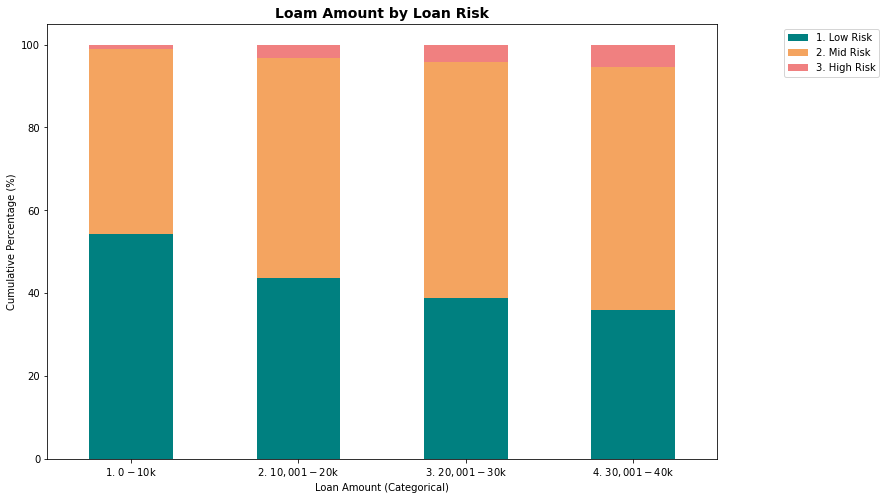

In [33]:
#Slice to get the grade_categorical and home ownership
loan_amt_chart = dataframe1[['grade_categorical','loan_amnt_cat']]

#Group by home ownership then grade
loan_amt_chart_grouped = loan_amt_chart.groupby(['loan_amnt_cat','grade_categorical'])['loan_amnt_cat'].count().unstack('grade_categorical')

#bar chart by percentage
loan_amt_chart_grouped2 = loan_amt_chart_grouped.div(loan_amt_chart_grouped.sum(axis=1),axis=0)*100

#display aggregated data
print(loan_amt_chart_grouped2)

#plot bar chart
loan_amt_chart_grouped2.plot(kind='bar',stacked=True,figsize=(12,8),color=colors)

#adjust legend to out of figure frame
plt.legend(bbox_to_anchor=(1.25,1))

#customise the x-axis
plt.xticks(rotation=0)

#x-axis, y-axis and title adjustment and labelling
plt.ylabel('Cumulative Percentage (%)')
plt.xlabel('Loan Amount (Categorical)')
plt.title('Loam Amount by Loan Risk',fontweight="bold",fontsize=14)

plt.show()

- Upon further analysis, it seems that higher loan amounts tend to have more high risk loans and less low risk loans

#### 4. Loan Risk and Loan Term

> #### Violin Plot

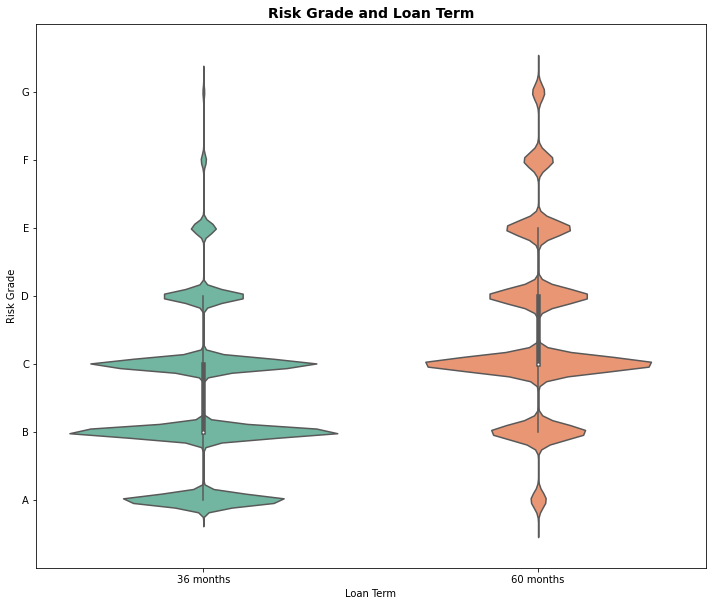

In [34]:
#set the figure size for the plot
plt.figure(figsize=(12,10)) 

#Seaborn - violin plot
sns.violinplot(data=dataframe1, x='term', y='grade_numerical', palette="Set2", cut=5, linewidth=1.5)

#configure the y-axis scale
plt.yticks(np.arange(0, 9, 1))

#customise the y-axis
plt.yticks([1, 2, 3, 4, 5, 6, 7],['A','B','C','D','E','F','G'],rotation=0)

#x-axis, y-axis and title adjustment and labelling
plt.xlabel('Loan Term')
plt.ylabel('Risk Grade')
plt.title('Risk Grade and Loan Term',fontweight="bold",fontsize=14)

plt.show()

- 36 months loan term has loans concentrated at the 'B' and 'C' risk grade, while 60 months loan term has loans that are concentrated at the 'C' risk grade
- It is clear that longer loan term has loans that has higher risk grades

#### 5. Loan Risk and Annual Income

> #### Hexbin Plot and Scatter Plot

<Figure size 864x720 with 0 Axes>

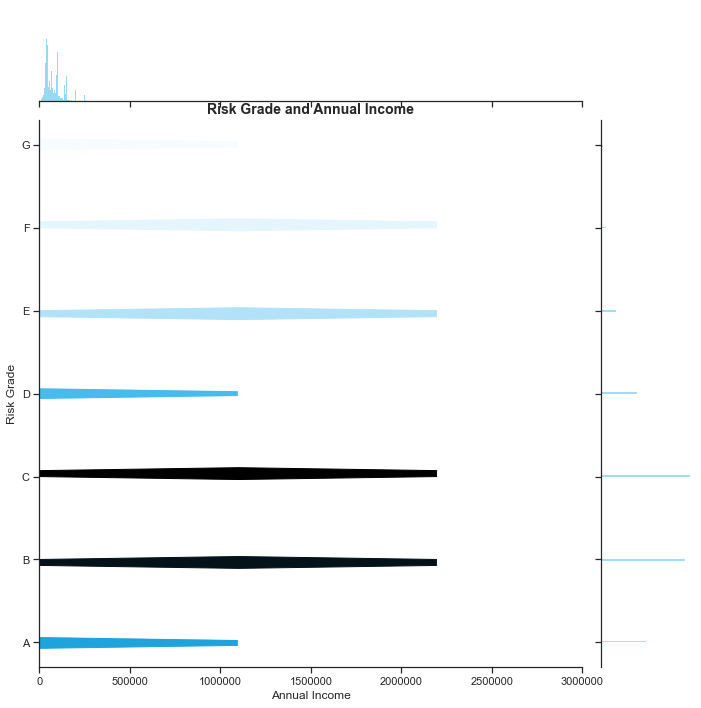

In [35]:
#set the figure size for the plot
plt.figure(figsize=(12,10)) 

#Hexbin plot with marginal distributions
sns.set_theme(style="ticks")
sns.jointplot(x='annual_inc', y='grade_numerical', data=dataframe1, kind="hex", color="#75CCF1",height=10)

#Change the x-axis to full numerical format instead of scientific format
plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)

#customise the y-axis
plt.yticks([1, 2, 3, 4, 5, 6, 7],['A','B','C','D','E','F','G'],rotation=0)

#x-axis, y-axis and title adjustment and labelling
plt.xlabel('Annual Income')
plt.ylabel('Risk Grade')
plt.title('Risk Grade and Annual Income',fontweight="bold",fontsize=14)

#magnify the plot
plt.xlim(0,3000000)

plt.show()

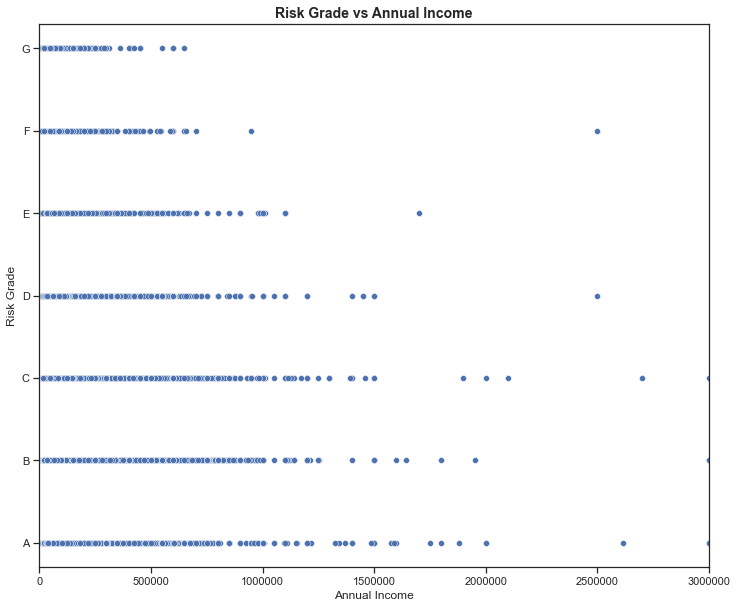

In [36]:
#set the figure size for the plot
plt.figure(figsize=(12,10)) 

#scatter
sns.scatterplot(x='annual_inc',y='grade_numerical',data=dataframe1)

#Change the x-axis to full numerical format instead of scientific format
plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)

#customise the y-axis
plt.yticks([1, 2, 3, 4, 5, 6, 7],['A','B','C','D','E','F','G'],rotation=0)

#x-axis, y-axis and title adjustment and labelling
plt.xticks(rotation=0)
plt.xlabel('Annual Income')
plt.ylabel('Risk Grade')
plt.title('Risk Grade vs Annual Income',fontweight="bold",fontsize=14)

#magnify the plot
plt.xlim(0,3000000)

plt.show()

- Loans are concentrated at the risk grade of 'B' and 'C', while annual income is concentrated at the "<500,000" region
- It seems that a lower annual income would contribute to a higher risk grade, however, the pattern is not distinct as there are low risk grades with low annual income

#### 6. Loan Risk and Loan Purpose

> #### Stacked Bar Chart

grade_categorical   1. Low Risk  2. Mid Risk  3. High Risk
purpose                                                   
house                 30.440887    60.600955      8.958158
small_business        32.070431    61.590771      6.338798
renewable_energy      35.452794    60.115607      4.431599
other                 38.482636    57.908445      3.608919
moving                36.380378    60.036832      3.582789
debt_consolidation    42.915904    54.045373      3.038723
major_purchase        50.264752    47.300617      2.434631
home_improvement      52.501005    45.425459      2.073535
medical               45.907336    52.191120      1.901544
vacation              47.911471    50.701372      1.387157
car                   55.235274    43.420303      1.344423
credit_card           58.711526    40.120303      1.168171
wedding               33.333333    66.666667           NaN


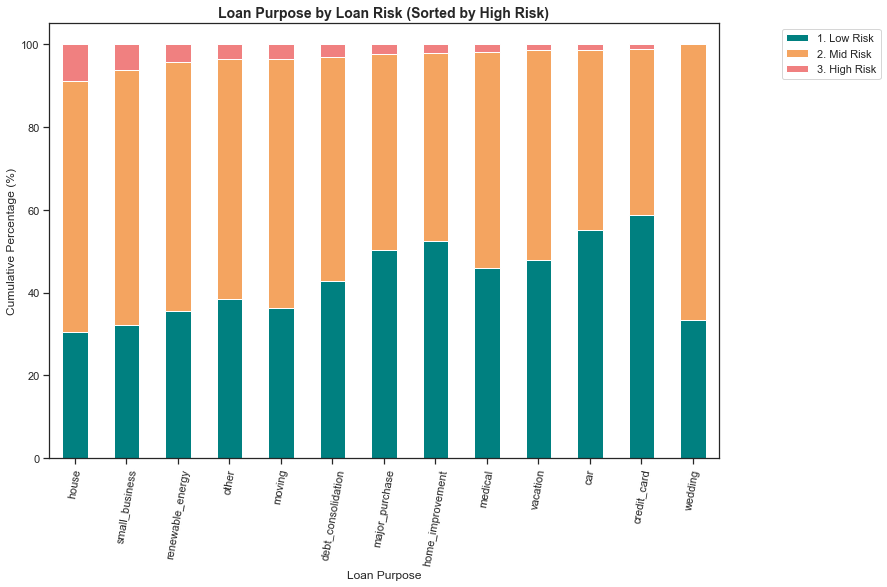

In [37]:
#Slice to get the grade_categorical and purpose
loan_purpose = dataframe1[['grade_categorical','purpose']]

#Group by purpose then grade
loan_purpose_grouped = loan_purpose.groupby(['purpose','grade_categorical'])['purpose'].count().unstack('grade_categorical')

#bar chart by percentage
loan_purpose_grouped2 = loan_purpose_grouped.div(loan_purpose_grouped.sum(axis=1),axis=0)*100

#sort by values in 3. High Risk
loan_purpose_grouped2.sort_values(by=['3. High Risk'],ascending=False,inplace=True)

#display aggregated data
print(loan_purpose_grouped2)

#plot bar chart
loan_purpose_grouped2.plot(kind='bar',stacked=True,figsize=(12,8),color=colors)

#adjust legend to out of figure frame
plt.legend(bbox_to_anchor=(1.25,1))

#x-axis, y-axis and title adjustment and labelling
plt.ylabel('Cumulative Percentage (%)')
plt.xlabel('Loan Purpose')
plt.xticks(rotation=80)
plt.title('Loan Purpose by Loan Risk (Sorted by High Risk)',fontweight="bold",fontsize=14)

plt.show()

- Loans that usually have high risk are those for 'house', 'small_business' and 'renewable energy'  
- For low risk loans, one should select 'credit_card', 'car' and 'home_improvement'

#### 7. Loan Risk and Home Ownership

> #### Stacked Bar Chart

grade_categorical      1. Low Risk  2. Mid Risk  3. High Risk
home_ownership_binary                                        
0                        46.847294    50.557617      2.595089
1                        46.397711    50.792559      2.809730


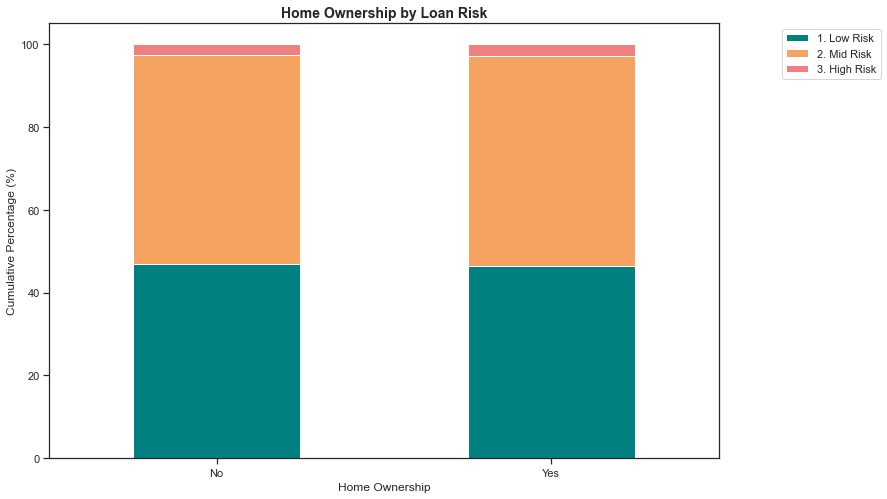

In [38]:
#Slice to get the grade_categorical and home ownership
own_home = dataframe1[['grade_categorical','home_ownership_binary']]

#Group by home ownership then grade
own_home_grouped = own_home.groupby(['home_ownership_binary','grade_categorical'])['home_ownership_binary'].count().unstack('grade_categorical')

#bar chart by percentage
own_home_grouped2 = own_home_grouped.div(own_home_grouped.sum(axis=1),axis=0)*100

#display aggregated data
print(own_home_grouped2)

#plot bar chart
own_home_grouped2.plot(kind='bar',stacked=True,figsize=(12,8),color=colors)

#adjust legend to out of figure frame
plt.legend(bbox_to_anchor=(1.25,1))

#customise the x-axis
plt.xticks([0, 1],['No','Yes'],rotation=0)

#x-axis, y-axis and title adjustment and labelling
plt.ylabel('Cumulative Percentage (%)')
plt.xlabel('Home Ownership')
plt.title('Home Ownership by Loan Risk',fontweight="bold",fontsize=14)

plt.show()

- Loan risk does not seem to be affected by home ownership since both home ownership results have similar percentages in the different risk grades

#### 8. Loan Risk and Borrower State

> #### Enrich dataframe1 by joining latitude and longitude data from html web page

In [39]:
#read the latitude and longitude data from google (required to put the [0], if not will be a list)
dataframe2=pd.read_html('https://developers.google.com/public-data/docs/canonical/states_csv')[0]

#rename column in dataframe2
dataframe2=dataframe2.rename(columns={'state':'addr_state'})

print(dataframe2.head())

  addr_state   latitude   longitude        name
0         AK  63.588753 -154.493062      Alaska
1         AL  32.318231  -86.902298     Alabama
2         AR  35.201050  -91.831833    Arkansas
3         AZ  34.048928 -111.093731     Arizona
4         CA  36.778261 -119.417932  California


In [40]:
#merge dataframe1 and dataframe2 together
inner_join=pd.merge(dataframe1,dataframe2,on=['addr_state'],how='inner')

#slice for easy viewing
loan_risk_state=inner_join[['addr_state','grade_numerical','latitude','longitude','name']]

print(loan_risk_state.head())

  addr_state  grade_numerical   latitude  longitude      name
0         NY                3  43.299428 -74.217933  New York
1         NY                4  43.299428 -74.217933  New York
2         NY                2  43.299428 -74.217933  New York
3         NY                2  43.299428 -74.217933  New York
4         NY                2  43.299428 -74.217933  New York


> #### Calculate the count and the average risk grade for each state

In [41]:
#get loan count by state
state_count = loan_risk_state.groupby(['name']).size()

#convert count to dataframe
state_count_df = state_count.to_frame()
state_count_df = state_count_df.reset_index()
state_count_df.columns = ['name','statecount']
print(state_count_df.head())

#get average risk rating by state
risk_rating = loan_risk_state[['name','grade_numerical']].groupby(['name'])
risk_rating_mean = risk_rating.mean()
risk_rating_mean = risk_rating_mean.reset_index()
print(risk_rating_mean.head())

         name  statecount
0     Alabama        9133
1      Alaska        1729
2     Arizona       18251
3    Arkansas        5742
4  California      101377
         name  grade_numerical
0     Alabama         2.790978
1      Alaska         2.724118
2     Arizona         2.667251
3    Arkansas         2.757053
4  California         2.658078


> #### Merge different calculated dataframes and drop duplicated rows to prepare for plotting

In [42]:
#merge loan_risk_state with state count
merged_df = pd.merge(loan_risk_state,state_count_df,on='name')

#drop duplicated state
merged_df.drop_duplicates(subset='name',inplace=True)

#rename column
merged_df = merged_df.rename(columns={'grade_numerical': 'Old Risk Rating'})

#merge with average risk rating
merged_df = pd.merge(merged_df,risk_rating_mean,on='name')

#rename column
merged_df = merged_df.rename(columns={'grade_numerical': 'AverageRiskGrade'})

#drop old risk rating and geometry column
merged_df = merged_df.drop(['Old Risk Rating'],axis=1)

print(merged_df.head())

  addr_state   latitude   longitude           name  statecount  \
0         NY  43.299428  -74.217933       New York       62974   
1         MA  42.407211  -71.382437  Massachusetts       17312   
2         CA  36.778261 -119.417932     California      101377   
3         MN  46.729553  -94.685900      Minnesota       13452   
4         PA  41.203322  -77.194525   Pennsylvania       25639   

   AverageRiskGrade  
0          2.729603  
1          2.601779  
2          2.658078  
3          2.664734  
4          2.706619  


> #### Preparing dataframes for Geo Plot 

In [43]:
# creating a geometry column 
geometry = [Point(xy) for xy in zip(merged_df['longitude'], merged_df['latitude'])]

# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}

# Creating a geographic data frame from merged_df
gdf = gpd.GeoDataFrame(merged_df, crs=crs, geometry=geometry)

#Merge state_count_df with the above gdf
state_with_counts = pd.merge(gdf,state_count_df,on='name')

#drop duplicated statecount column
state_with_counts = state_with_counts.drop(['statecount_y'],axis=1)

print(state_with_counts.head())

  addr_state   latitude   longitude           name  statecount_x  \
0         NY  43.299428  -74.217933       New York         62974   
1         MA  42.407211  -71.382437  Massachusetts         17312   
2         CA  36.778261 -119.417932     California        101377   
3         MN  46.729553  -94.685900      Minnesota         13452   
4         PA  41.203322  -77.194525   Pennsylvania         25639   

   AverageRiskGrade                     geometry  
0          2.729603   POINT (-74.21793 43.29943)  
1          2.601779   POINT (-71.38244 42.40721)  
2          2.658078  POINT (-119.41793 36.77826)  
3          2.664734   POINT (-94.68590 46.72955)  
4          2.706619   POINT (-77.19452 41.20332)  


/Users/jasonkhoo/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


> #### Geo Plot - Loan Risk and Borrower's State

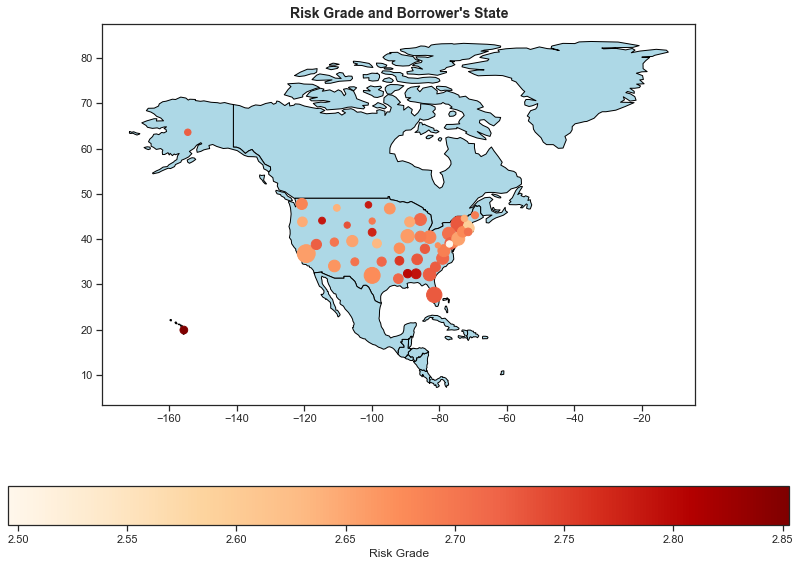

In [44]:
#get built in dataset from geopandas
world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#plot world map [Fiona is used here for the map]
axis = world_map[world_map.continent == 'North America'].plot(color = 'lightblue', edgecolor='black',figsize=(14,10))

#normalise the StateCount for the plotting (make the dot smaller)
state_with_counts['statecount_x_normalised'] = state_with_counts['statecount_x']**0.5

#plot the dots
state_with_counts.plot(ax=axis,markersize='statecount_x_normalised',column='AverageRiskGrade', cmap='OrRd',legend=True,legend_kwds={'label': 'Risk Grade', 'orientation':'horizontal'})

#set title
plt.title("Risk Grade and Borrower's State",fontweight="bold",fontsize=14)

plt.show()

> #### Geo Plot (Interactive) - Loan Risk and Borrower's State 

In [45]:
#create columns for mercator_x and mercator_y and convert longitude / latitude to mercator coordinates
k = 6378137
state_with_counts['mercator_x'] = state_with_counts['longitude'] * (k*np.pi/180.0)
state_with_counts['mercator_y'] = np.log(np.tan((90+state_with_counts['latitude'])*np.pi/360.0))*k

#drop off geometry
state_with_counts=state_with_counts.drop(columns='geometry')

print(state_with_counts.head())

  addr_state   latitude   longitude           name  statecount_x  \
0         NY  43.299428  -74.217933       New York         62974   
1         MA  42.407211  -71.382437  Massachusetts         17312   
2         CA  36.778261 -119.417932     California        101377   
3         MN  46.729553  -94.685900      Minnesota         13452   
4         PA  41.203322  -77.194525   Pennsylvania         25639   

   AverageRiskGrade  statecount_x_normalised    mercator_x    mercator_y  
0          2.729603               250.946209 -8.261903e+06  5.357659e+06  
1          2.601779               131.575074 -7.946257e+06  5.222174e+06  
2          2.658078               318.397550 -1.329354e+07  4.408244e+06  
3          2.664734               115.982757 -1.054039e+07  5.898041e+06  
4          2.706619               160.121829 -8.593255e+06  5.042378e+06  


In [46]:
#to allow bokeh to open in notebook instead of a separate tab
bokeh.io.output_notebook(INLINE)

#choose color palette
palette = PRGn[4]

#specify the source of the data
source = ColumnDataSource(data=state_with_counts)

#color mapper - set column that will affect the colour of the data points
color_mapper = linear_cmap(field_name = 'AverageRiskGrade', palette = palette, 
                           low = state_with_counts['AverageRiskGrade'].min(), high = state_with_counts['AverageRiskGrade'].max())

#set tooltips - data labels will appear when we hover over a data point
tooltips = [("Borrower State","@name"), ("Average Risk Rating","@AverageRiskGrade"),("Loan Count","@statecount_x")]

#create figure and set range bounds in web mercator coordinates
p = figure(plot_width=950, plot_height=600, x_range=(-20000000, -2000000), y_range=(200000, 8000000),
           x_axis_type="mercator", y_axis_type="mercator",x_axis_label='Longitude'
           ,y_axis_label='Latitude',tooltips=tooltips)

#add tile
tile_provider = get_provider(CARTODBPOSITRON_RETINA)
p.add_tile(tile_provider)

#add points using mercator coordinates
p.circle(x = 'mercator_x', y = 'mercator_y', color = color_mapper, source=source, size=10, fill_alpha = 0.9)

#defines color bar
color_bar = ColorBar(color_mapper=color_mapper['transform'], 
                     formatter = NumeralTickFormatter(format='0.0[0000]'), 
                     label_standoff = 13, width=8, location=(0,0))

#set color_bar location
p.add_layout(color_bar, 'right')

#show title
p.title.text = "Loan Risk and Borrower's State"

#show map
show(p)

Loading BokehJS ...

- The higher risk loans are from borrowers whose states are Hawaii, Alabama, Mississippi, Nebraska, North Darkota and Idaho
- Borrowers from Columbia has the lowest risk loans

## E. Conclusion <a id = "conclusion"></a> 

Based on the analysis, a summary of the findings is listed down as follows:

#### 1. Loan Amount
- Higher loan amount increases loan risk

#### 2. Loan Term
- Higher loan term increases loan risk

#### 3. Borrower's Annual Income
- Slight observation that higher annual income decreases loan risk

#### 4. Loan Purpose
- Loans for credit card, car and home improvement tend to have lower risk
- Loans for house, small business and renewable energy tend to have higher risk

#### 5. Home Ownership
- Insignificant impact on the risk grade

#### 6. Borrower's State
- Borrowers from Columbia have lower risk
- Borrowers from Hawaii, Alabama, Mississippi, Nebraska, North Darkota and Idaho have higher risk


Apart from the loan attributes abovementioned, lenders (investors) should also take note of the interactions between the loan risk and return (as represented by the interest rates) in their investment decisions. Even though a lower risk loan can lead to a better loan outcome presented in the analysis above, they should keep in mind that that lower risk loan has lower returns. 

### Future Research

Possible utilisation of machine learning approaches and models to: 
1. Verify accuracy of the existing risk grading system at LendingClub, and
2. Predict (1) the risk rating of new loans based on the attributes provided by the borrowers as part of the onboarding process and (2) the probability of loan default.

## Credits

Cover Image Attribution: Pixabay (www.pixabay.com)